    k-means 算法在不带标签的多维数据集中寻找确定数量的簇。最优的聚类结果需要符合以
    下两个假设:
* “簇中心点”（cluster center）是属于该簇的所有数据点坐标的算术平均值。
* 一个簇的每个点到该簇中心点的距离，比到其他簇中心点的距离短

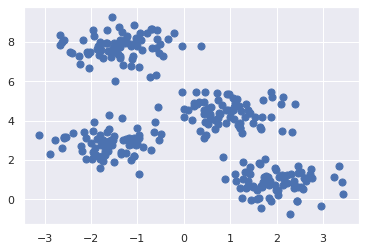

In [2]:
#创建数据集
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
from sklearn.datasets import make_blobs
X,y_true = make_blobs(n_samples=300,centers=4,cluster_std=0.6,random_state=0)
plt.scatter(X[:,0],X[:,1],s=50)

In [4]:
#sklearn的KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

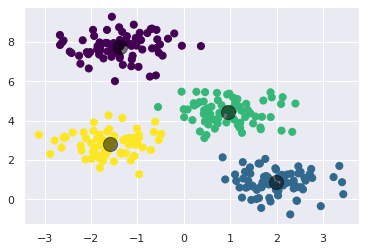

In [5]:
#聚类结果可视化，标记簇中心点
plt.scatter(X[:,0],X[:,1],c=y_kmeans,s=50,cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=200,alpha=0.5)

k-means算法:期望最大化

期望最大化方法包含以下步骤。
(1) 猜测一些簇中心点。
(2) 重复直至收敛。
* 期望步骤（E-step）：将点分配至离其最近的簇中心点。
* 最大化步骤（M-step）：将簇中心点设置为所有点坐标的平均值

期望步骤不断更新每个点是属于哪一簇的期望值，最大化步骤计算关于簇中心点的拟合函数值最大化对应坐标

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X,n_clusters,rseed=2):
    
    rg = np.random.RandomState(rseed)
    i = rg.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        
        labels = pairwise_distances_argmin(X,centers)
        new_centers = np.array([X[labels==i].mean(0) 
                                for i in range(n_clusters)])
        
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers,labels

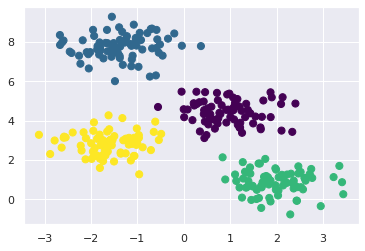

In [7]:
centers,labels = find_clusters(X,4)
plt.scatter(X[:,0],X[:,1],c=labels,s=50,cmap="viridis");

**使用期望最大化算法的注意事项**

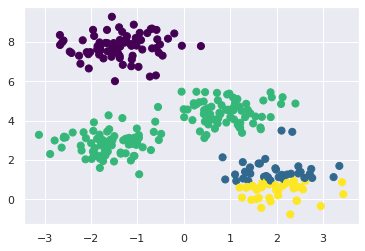

In [8]:
#1 可能不会达到全局最优结果(随机种子)
#由随机种子确定的初始值导致比较差的结果
centers,labels = find_clusters(X,4,rseed=0)
plt.scatter(X[:,0],X[:,1],s=50,c=labels,cmap="viridis")

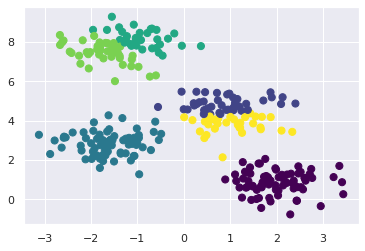

In [9]:
#2 簇的数量必须事先定好,算法不能学习到簇的数量
labels =KMeans(6,random_state=0).fit_predict(X)
plt.scatter(X[:,0],X[:,1],c=labels,s=50,cmap = 'viridis');

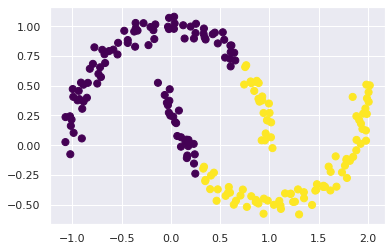

In [10]:
#3 k-means算法只能确定聚类边界
#当簇中心点呈现非线性复杂形状时，该算法通常不起作用

from sklearn.datasets import make_moons

X,y = make_moons(200,noise=0.05,random_state=0)
labels = KMeans(2,random_state=0).fit_predict(X)
plt.scatter(X[:,0],X[:,1],c=labels,s=50,cmap='viridis');

/home/liuhao/.local/lib/python3.6/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


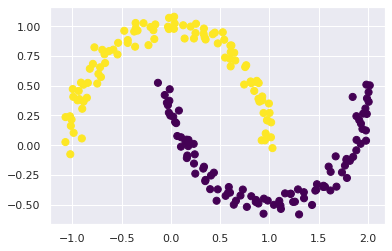

In [13]:
#核kmeans算法聚类非线性数据
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2,affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:,0],X[:,1],c=labels,s=50,cmap='viridis');

In [14]:
#4 当数据量较大时,kmeans很慢,因为每次迭代都遍历所有点

案例

**案例1 用kmeans算法处理手写数字**

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [16]:
kmeans = KMeans(n_clusters=10,random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

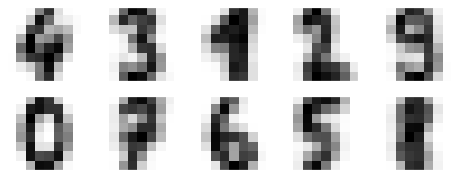

In [17]:
#可视化簇中心点
fig,ax = plt.subplots(2,5,figsize=(8,3))
centers = kmeans.cluster_centers_.reshape(10,8,8)
for axi,center in zip(ax.flat,centers):
    axi.set(xticks=[],yticks=[])
    axi.imshow(center,interpolation='nearest',cmap=plt.cm.binary)

In [19]:
#将学习到的簇标签与真实标签匹配
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters==i)
    labels[mask] = mode(digits.target[mask])[0]
#mode函数返回传入数组/矩阵中最常出现的成员以及出现的次数    

In [20]:
#检查聚类算法在查找相似数字时的准确性

from sklearn.metrics import accuracy_score
accuracy_score(digits.target,labels)

0.7952142459654981

Text(89.18, 0.5, 'predicted label')

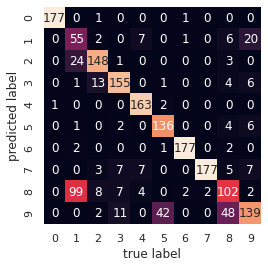

In [21]:
#查看混淆矩阵
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(digits.target,labels)
sns.heatmap(mat.T,square = True,annot=True,fmt="d",cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

#1被判成8居多

In [24]:
#使用t-SNE非线性嵌入法在kmeans之前对数据预处理
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,init='pca',random_state=0)
digits_proj = tsne.fit_transform(digits.data)

kmeans = KMeans(n_clusters=10,random_state=0)
clusters = kmeans.fit_predict(digits_proj)

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters==i)
    labels[mask] = mode(digits.target[mask])[0]
    
accuracy_score(digits.target,labels)    

0.9398998330550918

**案例2:将kmeans用于色彩压缩**

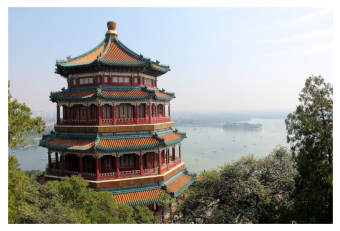

In [25]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg')
ax = plt.axes(xticks=[],yticks=[])
ax.imshow(china)

In [26]:
#查看图像维度
china.shape#三个维度分别是(height,width,RGB)

(427, 640, 3)

In [28]:
#将像素转换成三维空间数据点
data = china / 255.0
data = data.reshape(427*640,3)
data.shape

(273280, 3)

In [32]:
#对前10000个像素可视化

def plot_pixel(data,title,colors=None,N=10000):
    if colors is None:
        colors=data
        
    rg = np.random.RandomState(0)
    i = rg.permutation(data.shape[0])[:N]
    colors = colors[i]
    R,G,B = data[i].T
    
    fig,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].scatter(R,G,color=colors,marker=".")
    ax[0].set(xlabel="Red",ylabel="Green",xlim = (0,1),ylim=(0,1))
    
    ax[1].scatter(R,B,color=colors,marker=".")
    ax[1].set(xlabel="Red",ylabel='Blue',xlim=(0,1),ylim=(0,1))
    
    fig.suptitle(title,size=20)

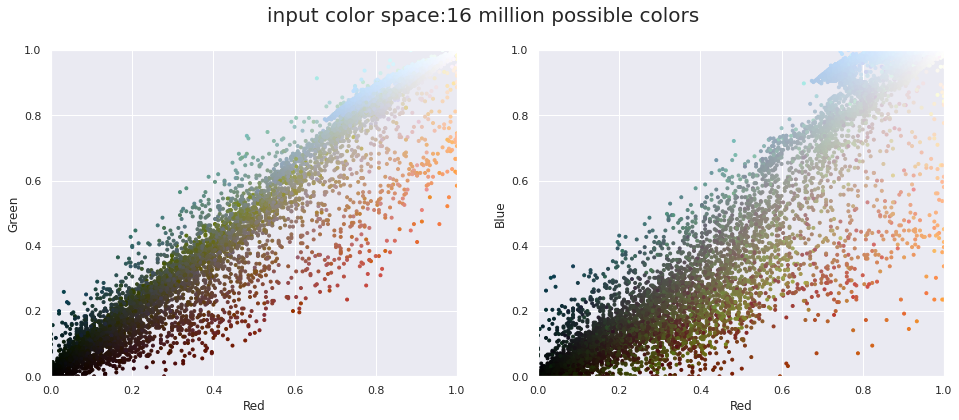

In [33]:
plot_pixel(data,title="input color space:16 million possible colors")

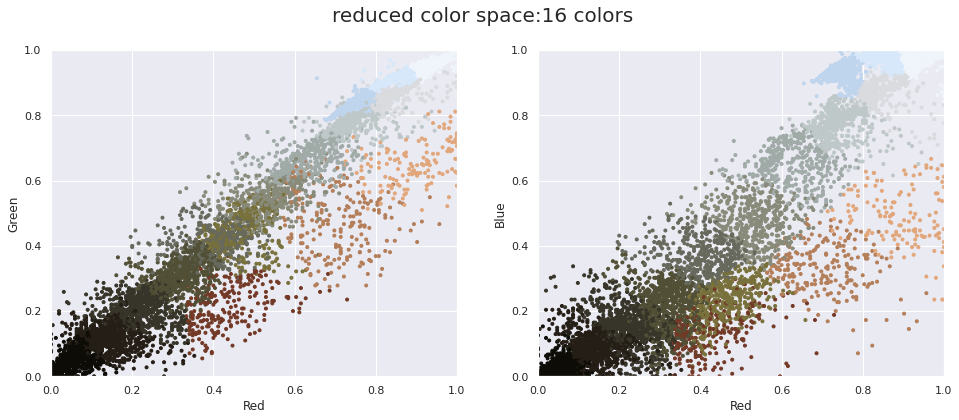

In [36]:
#使用kmeans将1600万种颜色(255*255*255)缩减到16种
#由于数据集很大，所以使用MiniBatchKMeans算法

from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixel(data,colors=new_colors,title='reduced color space:16 colors')

Text(0.5, 1.0, '16-colot Image')

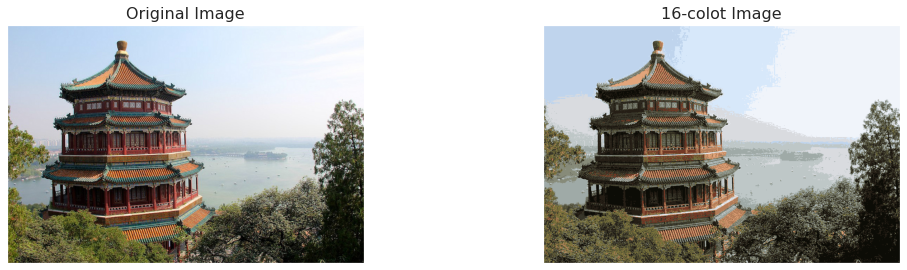

In [38]:
#用聚类结果对原始像素重新着色
china_reloader = new_colors.reshape(china.shape)

fig,ax = plt.subplots(1,2,figsize=(16,6),
                     subplot_kw=dict(xticks=[],yticks=[]))
fig.subplots_adjust(wspace=0.5)

ax[0].imshow(china)
ax[0].set_title('Original Image',size=16)
ax[1].imshow(china_reloader)
ax[1].set_title('16-colot Image',size=16)